# ME8813ML Homework 1: 
##  Implement a quasi-Newton optimization method for data fitting
## Name: Donaven Lobo

### Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Task:
##          Implement a parameter fitting function fit() so that p = DFP_fit(x,y)
##          returns a list of the parameters as p of model:
##          p_0 + p_1*cos(2*pi*x) + p_2*cos(4*pi*x) + p_3*cos(6*pi*x) 

### GLOBAL VARIABLES:

In [2]:
PI = np.pi

### PROVIDED CODE: Creates a random dataset

In [9]:
# Fixing random state for reproducibility
np.random.seed(19680801)

dx = 0.1
x_lower_limit = 0
x_upper_limit = 40                                       
x = np.arange(x_lower_limit, x_upper_limit, dx)
data_size = len(x)                                 # data size
noise = np.random.randn(data_size)                 # white noise

# Calculate noise
noise_sq = np.dot(noise.T,noise)
print("Here are the final values of noise: {p_values}".format(p_values=noise_sq))

# Original dataset 
y = 2.0 + 3.0*np.cos(2*np.pi*x) + 1.0*np.cos(6*np.pi*x) + noise

Here are the final values of noise: 395.5639556255188


### COMPLETE: Initialization and call to DFP_fit function

In [5]:
initial_p = np.ones(4) * 2  # Initial parameter guess
eps = 0.001  # Convergence threshold
p, y_p = DFP_fit(x, y, initial_p, eps)
print("Here are the final values of p: {p_values}".format(p_values=p))

The loss for the current prediction is: 787.2673956770294
The loss for the current prediction is: 395.23831710931177
The loss for the current prediction is: 395.23831710931177
Here are the final values of p: [ 2.02423712  3.00653652 -0.03718026  0.98640782]


### PROVIDED CODE: Plotting code

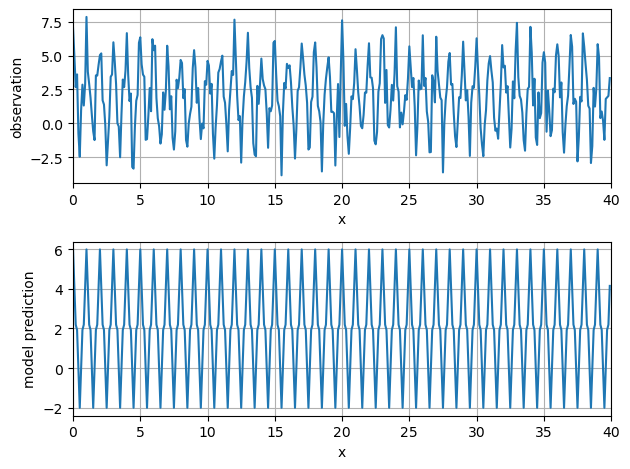

In [10]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(x, y)
axs[0].set_xlim(x_lower_limit, x_upper_limit)
axs[0].set_xlabel('x')
axs[0].set_ylabel('observation')
axs[0].grid(True)


#########################################
## Plot the predictions from your fitted model here
axs[1].plot(x, y_p)
axs[1].set_xlim(x_lower_limit, x_upper_limit)
axs[1].set_xlabel('x')
axs[1].set_ylabel('model prediction')
axs[1].grid(True)

fig.tight_layout()
plt.show()

### COMPLETE: Create my own DFP_Fit function

In [4]:
def DFP_fit(x,y,p,eps):
    #  Implement this function to calculate the p values
    
    def model(p):
        # Base values of the objective funtion
        base = np.array([np.ones_like(x), np.cos(2*PI*x), np.cos(4*PI*x), np.cos(6*PI*x)])
        
        # Calculate initial y_predicted value
        return np.dot(base.T, p)
        
    
    def loss_func(y_p):
        # Define specific loss function here
        return np.sum((y_p - y)**2)
        
    def gradient(y_p):
        # Gradient function was calculated manually - will need to verify if done corrently
        grad = np.array([np.sum(2*(y_p-y)),
                         np.sum(2*(y_p-y)*np.cos(2*PI*x)),
                         np.sum(2*(y_p-y)*np.cos(4*PI*x)),
                         np.sum(2*(y_p-y)*np.cos(6*PI*x))
                        ])
        
        return grad
    
    def stop_cond(p, p_prev): 
        # Currently utilizing stopping condition 3 from lecture
        
        del_p = p - p_prev
        term1 = np.sqrt(np.dot(del_p.T,del_p))
        term2 = np.sqrt(eps) * (1 + np.sqrt(np.dot(p.T,p)))
        
        return (term1 < term2)
        

    def line_search(p, d): # Backwards line search
        # Initialize alpha
        alpha = 4

        #Continue iterating as long as the loss is reducting
        while (loss_func(model(p + alpha * d))) > loss_func(model(p)):
            alpha /= 2 # Divide learning rate by half
        return alpha
    

    # Calculate initial y_predicted value
    y_p = model(p)

    # Set the initial Heissen Matrix inverse approx (B_0) as the identity matrix
    B = np.eye(len(p)) #B_0 = I
    
    # Get the initial gradient of y
    grad = gradient(y_p) 

    
    p_prev = np.zeros(4) # Initialize a p_prev for stopping condition

    while not stop_cond(p, p_prev):
        p_prev = p.copy() # Set the previous p for stopping condition (had to set copy() due to pointer issue)
        
        d = -np.dot(B,grad) # update search direction (Step 1)
        alpha = line_search(p,d) # Line search for alpha (Step 2)
        p_del = np.dot(alpha, d) # Calculate difference between new and previous p values (Step 3) 
        p += p_del # Calculate new p value
        
        # Calculate difference between new and previous gradient values (Step 4)
        y_p = model(p) # Update predicted value
        grad_new = gradient(y_p)
        grad_del = grad_new - grad
        grad = grad_new # Update grad
        
        #Print out the loss to help with debugging
        loss = loss_func(y_p)
        print("The loss for the current prediction is: {loss}".format(loss=loss))
         
        # Calculate the new B value (Separate terms)
        B_t1 = np.outer(p_del,p_del)/np.dot(p_del.T,grad_del) # Term 1 of B recalculation

        # Term 2 of B recalculation
        B_t2_num = -np.dot(np.dot(np.dot(B, grad_del),grad_del.T), B)
        B_t2_den = np.dot(np.dot(grad_del.T,B),grad_del)
        B_t2 = B_t2_num / B_t2_den
        
        B += B_t1 + B_t2 # Update B here
    
    return p, y_p